<a href="https://colab.research.google.com/github/MaschinenNah/FramePred2021/blob/main/FramePred2021_04_moving_objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage import draw
import numpy as np
from matplotlib import pyplot as plt
import random

!git clone https://github.com/MaschinenNah/ml_utils
from ml_utils import show
from ml_utils import convert

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Cloning into 'ml_utils'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 124 (delta 57), reused 86 (delta 26), pack-reused 0
Receiving objects: 100% (124/124), 14.76 KiB | 14.76 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Thu Aug 26 08:29:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                  

In [2]:
from ml_utils import convert


###Eine Funktion, die bewegte Objekte in ein Numpy Array "hineinmalt"

Ein Etappenziel besteht darin, einen Generator zu programmieren, der Trainingsdaten für die Frame Prediction erzeugt.

Ein einzelnes Trainingsbeispiel soll aus einer Folge von vorherigen Frames (x) und einer Folge von zukünftigen Frames (y) bestehen.

Wir wollen dabei möglichst flexibel sein: Die Anzahl und Art der bewegten Objekte, die Größe des einzelnen Frames etc. sollen leicht zu ändern sein.

Zu diesem Behufe definieren wir eine Funktion, die den Bewegungsablauf eines einzelnen Objektes in ein Numpy Array hineinmalt.

Das einzige Argument arr ist ein Numpy Array. Hier gibt es nur folgende Vorgaben:

arr[i] ist ein einzelner Frame

Ensprechend bedeutet, wenn arr.shape[0] == 24, dass die Sequenz aus 24 Frames besteht.

Die Ausdehnungen der zweiten und dritten Dimension ist gleich, sprich: Die einzelnen Frames sind quadratisch!

In [26]:
def write_moving_object_into(arr):
  
  # Anzahl der Frames wird direkt aus der shape gefolgert:
  n_frames = arr.shape[0]
  # Ebenso die Größe der Frames:
  frame_size = arr.shape[1]

  # Bestimmung von Ausdehnung, Startposition und Geschwindigkeit des Objektes per Zufall:
  r = random.uniform(frame_size/12, frame_size/6)
  xpos = random.uniform(2*r, frame_size-2*r)
  ypos = random.uniform(2*r, frame_size-2*r)
  xspeed = random.uniform(frame_size/10., frame_size/7.) * random.choice([-1,1])
  yspeed = random.uniform(frame_size/10., frame_size/7.) * random.choice([-1,1])

  # Kreis oder Quadrat?
  renderer = random.randint(0, 1)

  # Berechnung der Bewegungssequenz:
  for i in range(0, n_frames):

    xpos_new = xpos + xspeed
    if xpos_new < 0 or xpos_new > frame_size:
      xspeed *= -1
    else:
      xpos = xpos_new
    
    ypos_new = ypos + yspeed
    if ypos_new < 0 or ypos_new > frame_size:
      yspeed *= -1
    else:
      ypos = ypos_new

    if renderer == 0:
      for j in range(0, round(frame_size/15)):
        # Hier findet das Malen statt:
        y, x = draw.circle_perimeter(round(xpos), round(ypos), round(r-j), shape=(frame_size, frame_size))
        # y, x = draw.circle(round(xpos), round(ypos), round(r-j), shape=(frame_size, frame_size))
        arr[i, y, x] = 1
      
    elif renderer == 1:
      for j in range(0, round(frame_size/15)):
        # Hier findet das Malen statt:
        y, x = draw.rectangle_perimeter((round(xpos)-r+j, round(ypos)-r+j), extent=(2*r-2*j, 2*r-2*j), shape=(frame_size, frame_size))
        # y, x = draw.rectangle((round(xpos)-r+j, round(ypos)-r+j), extent=(2*r-2*j, 2*r-2*j), shape=(frame_size, frame_size))
        y = y.astype("uint8")
        x = x.astype("uint8")
        arr[i, y, x] = 1

##Die Anwendung der Funktion

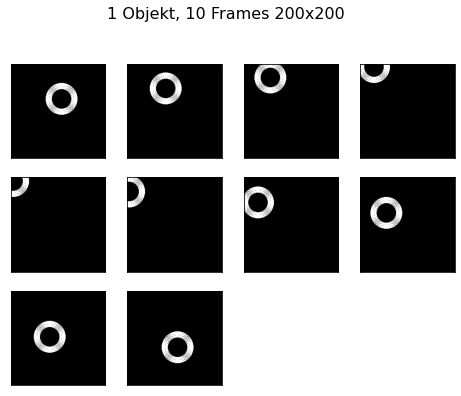

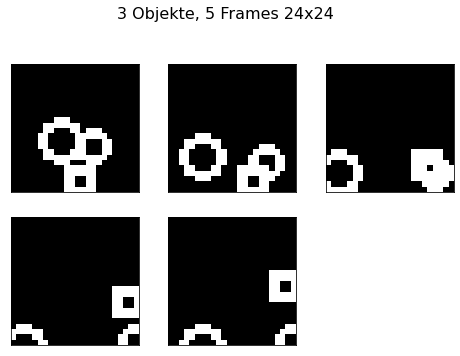

In [27]:
# Hier bauen wir eine Sequenz aus 10 Frames, 200 x 200 Pixel mit einem Objekt:
arr = np.zeros((10, 200, 200))
write_moving_object_into(arr)
show.show_images_from_np_array(arr, "1 Objekt, 10 Frames 200x200")

# Und eine Sequenz aus 5 Frames, 24 x 24:
arr = np.zeros((5, 24, 24))
write_moving_object_into(arr)
write_moving_object_into(arr)
write_moving_object_into(arr)
show.show_images_from_np_array(arr, "3 Objekte, 5 Frames 24x24")

## Ein Generator

In [21]:
from tensorflow.keras.utils import Sequence

class FramePredGen(Sequence):

  def __init__(self,
               frame_shape,
               n_frames_x,
               n_frames_y,
               n_objects,
               object_generator,
               len=50,
               batch_size=50):

    self.frame_shape = frame_shape
    self.n_frames_x = n_frames_x
    self.n_frames_y = n_frames_y
    self.n_objects = n_objects
    self.object_generator = object_generator
    self.len = len
    self.batch_size = batch_size
    
    self.all_examples = []


  def __len__(self):
    return self.len

  def __getitem__(self, batch_index):
    if batch_index >= self.len:
      raise IndexError("batch index out of range")
    else:
      batch_x, batch_y = self._get_empty_batch()
      for example_index in range(self.batch_size):
        all_frames = np.zeros((self.n_frames_x + self.n_frames_y,) + self.frame_shape)
        for object_index in range(self.n_objects):
          self.object_generator(all_frames)

        x = all_frames[:self.n_frames_x]
        y = all_frames[self.n_frames_x]

        batch_x[example_index] = x
        batch_y[example_index] = y
      
      return batch_x, batch_y

  # Hilfsfunktion – Erzeugung leerer Batches:
  def _get_empty_batch(self):
    empty_batch_x = np.zeros((self.batch_size,) + (self.n_frames_x,) + (self.frame_shape), "float32")
    empty_batch_y = np.zeros((self.batch_size,) + (self.n_frames_y,) + (self.frame_shape), "float32")
    return empty_batch_x, empty_batch_y



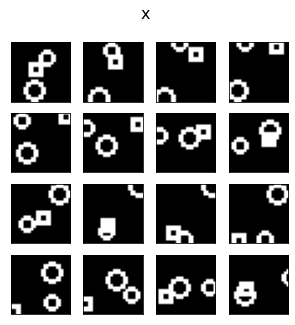

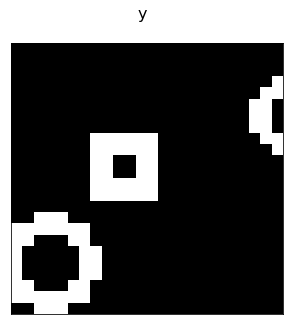

In [29]:
shape = (24, 24)

gen = FramePredGen(shape, 16, 1, 3, write_moving_object_into)

batch = gen[0]

show.show_images_from_np_array(batch[0][0], "x", width=5)
show.show_images_from_np_array(batch[1][0], "y", width=5)

#batch[0].shape

#show.show_frame_prediction_batch(batch)

In [30]:
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Conv3D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# Construct the input layer with no definite frame size.
inp = Input(shape=(None, *shape, 1))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = BatchNormalization()(x)
x = ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = BatchNormalization()(x)
x = ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="relu",
)(x)
x = Conv2D(
    filters=1, kernel_size=(3, 3), activation="tanh", padding="same"
)(x)
x = Reshape((1,*shape))(x)



# Next, we will build the complete model and compile it.
model = Model(inp, x)
model.summary()
model.compile(
    loss=binary_crossentropy, optimizer=Adam(),
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 24, 24, 1)] 0         
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, None, 24, 24, 64)  416256    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 24, 24, 64)  256       
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, None, 24, 24, 64)  295168    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 24, 24, 64)  256       
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, 24, 24, 64)        33024     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 1)         577 

In [41]:
model.fit(gen, epochs=1000)

Epoch 1/1000
50/50 [==============================] - 38s 748ms/step - loss: 0.1757
Epoch 2/1000
50/50 [==============================] - 37s 738ms/step - loss: 0.1739
Epoch 3/1000
50/50 [==============================] - 38s 759ms/step - loss: 0.1706
Epoch 4/1000
50/50 [==============================] - 37s 740ms/step - loss: 0.1731
Epoch 5/1000
50/50 [==============================] - 38s 754ms/step - loss: 0.1769
Epoch 6/1000
50/50 [==============================] - 38s 750ms/step - loss: 0.1721
Epoch 7/1000
50/50 [==============================] - 38s 761ms/step - loss: 0.1724
Epoch 8/1000
50/50 [==============================] - 38s 744ms/step - loss: 0.1700
Epoch 9/1000
50/50 [==============================] - 38s 755ms/step - loss: 0.1662
Epoch 10/1000
50/50 [==============================] - 38s 742ms/step - loss: 0.1672
Epoch 11/1000
50/50 [==============================] - 37s 740ms/step - loss: 0.1641
Epoch 12/1000
50/50 [==============================] - 38s 758ms/step - lo

KeyboardInterrupt: ignored

In [ ]:
batch = gen[0]
print(batch[1].shape)
pred = model.predict(batch[0])
actual = batch[1]
print(pred.shape)
show.show_images_from_np_array(pred.reshape(50, 24, 24), "pred")
show.show_images_from_np_array(actual.reshape(50, 24, 24), "act")

In [34]:
def predict_single(model, input):
  input = input[np.newaxis, ...]
  output = model.predict(input)[0]
  return output

def dream_step(model, input):
  predicted_image = predict_single(model, input)
  
  output = np.empty_like(input)
  output[:-1] = input[1:]
  output[-1] = predicted_image
  return output

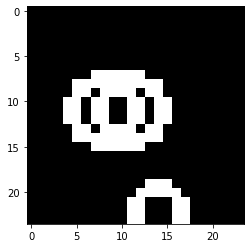

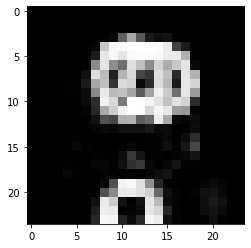

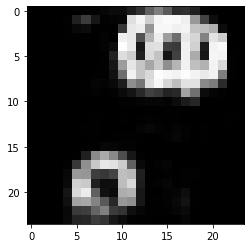

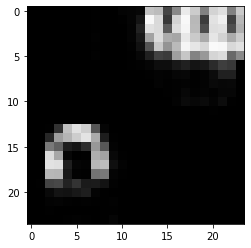

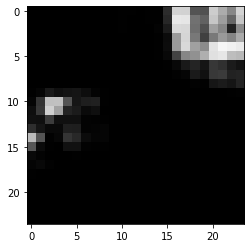

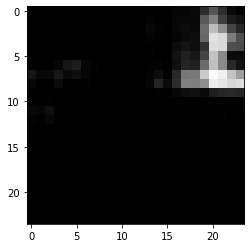

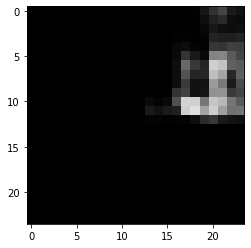

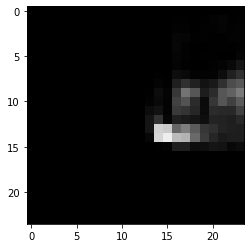

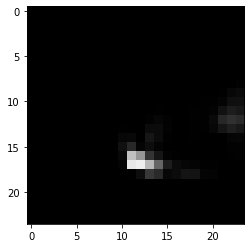

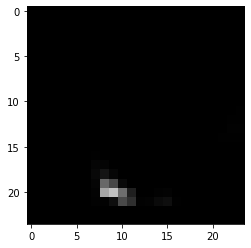

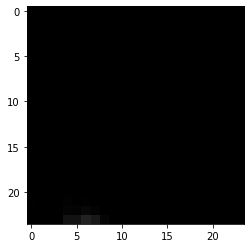

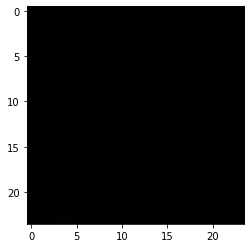

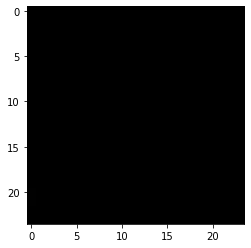

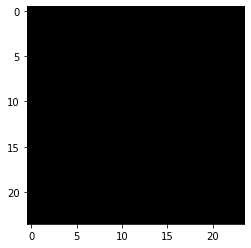

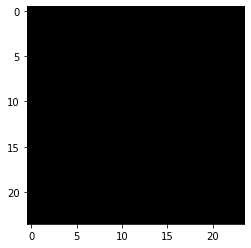

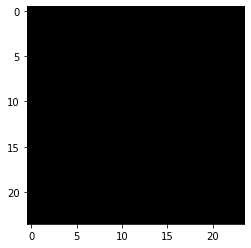

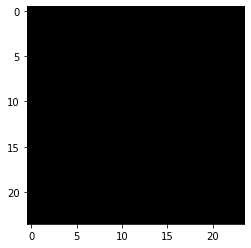

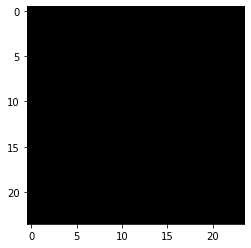

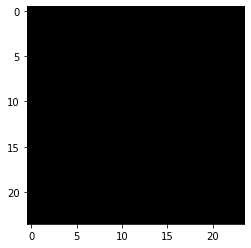

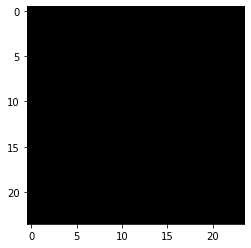

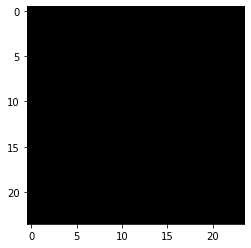

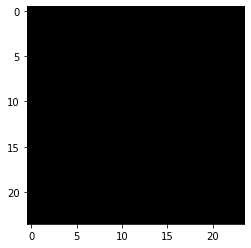

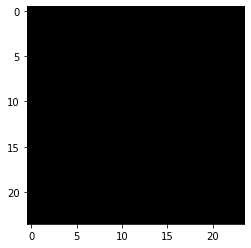

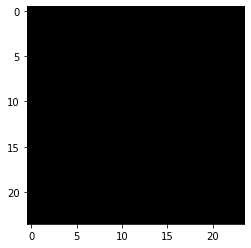

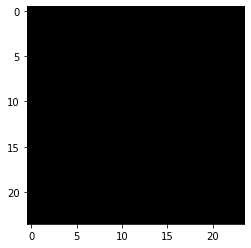

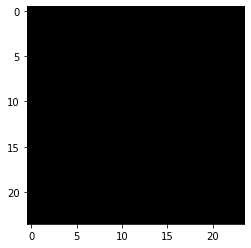

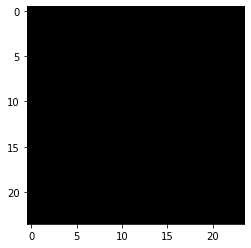

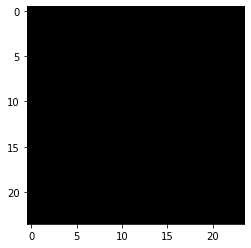

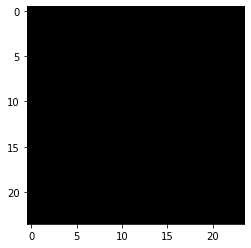

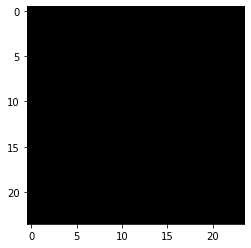

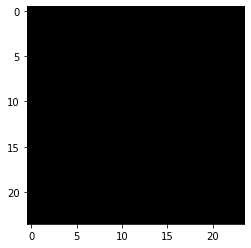

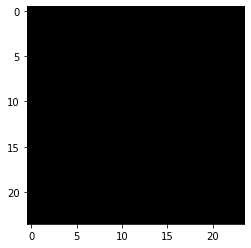

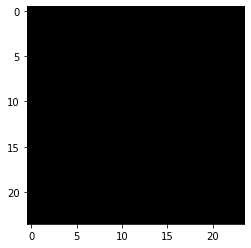

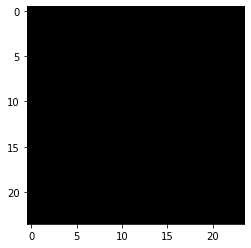

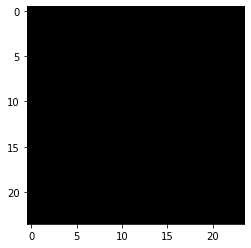

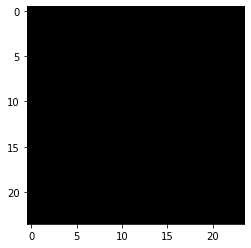

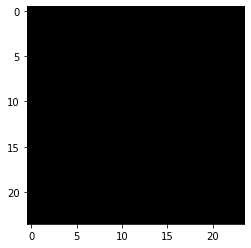

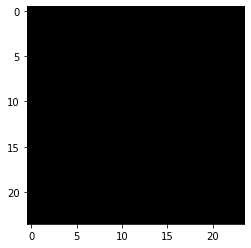

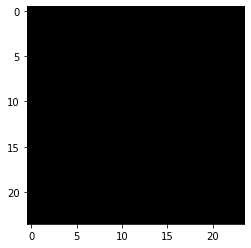

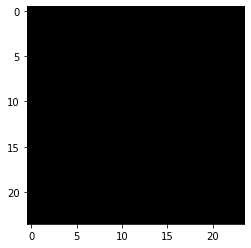

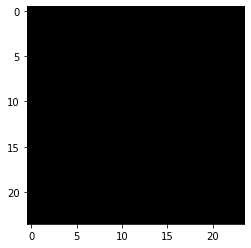

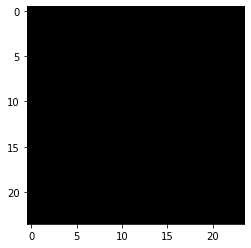

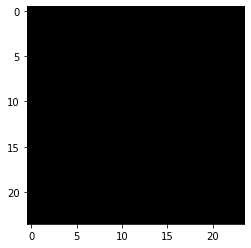

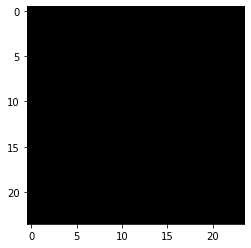

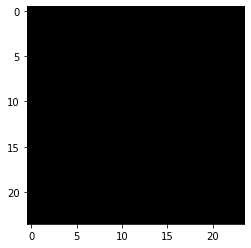

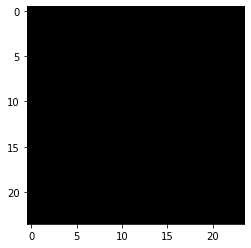

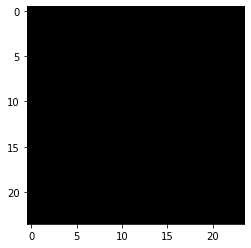

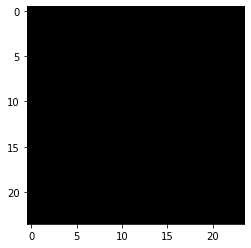

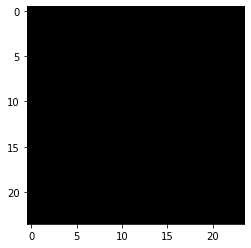

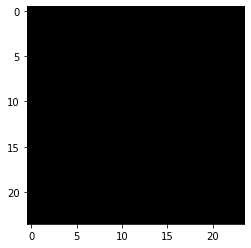

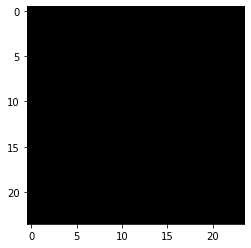

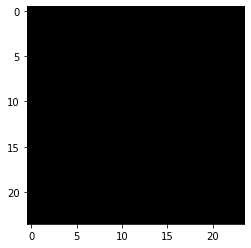

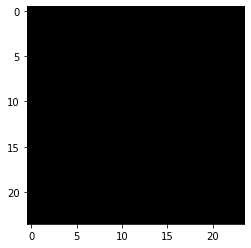

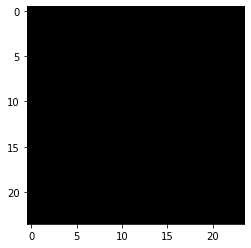

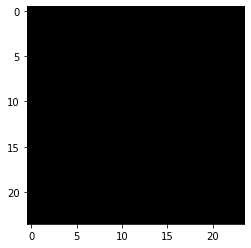

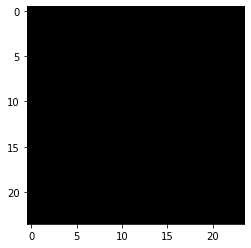

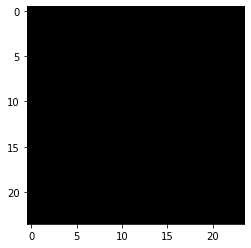

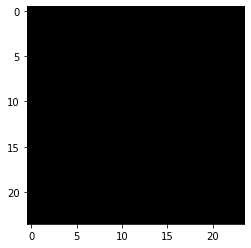

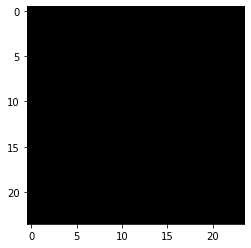

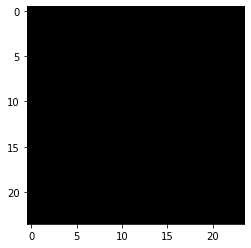

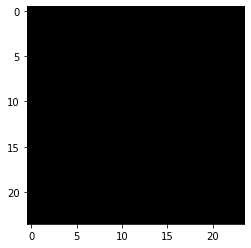

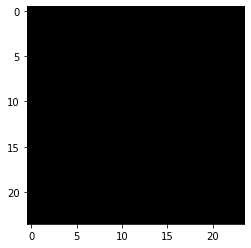

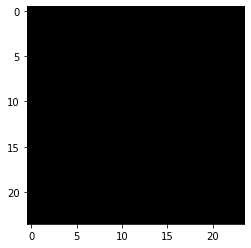

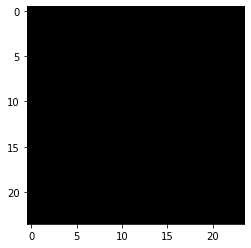

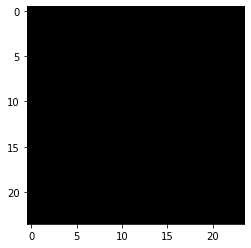

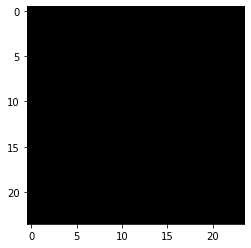

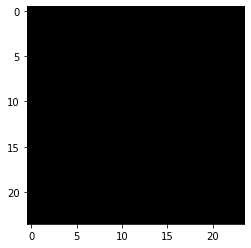

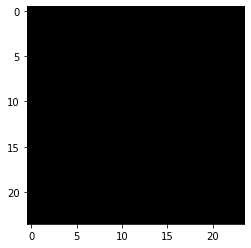

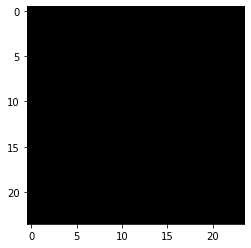

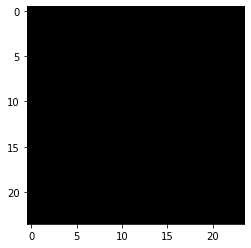

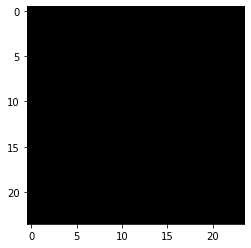

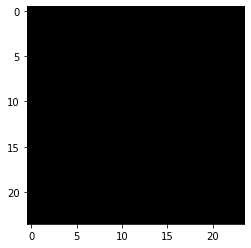

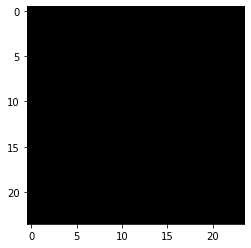

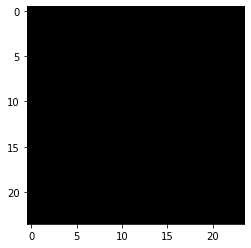

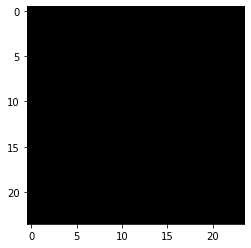

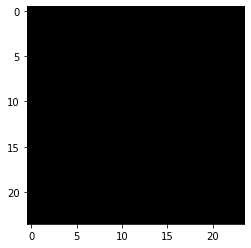

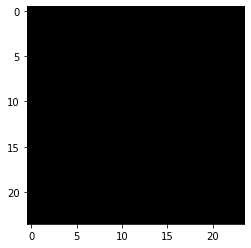

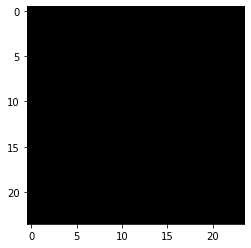

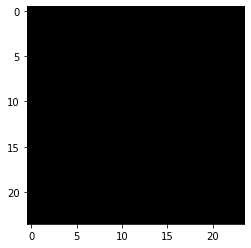

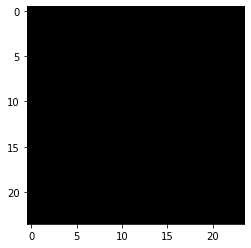

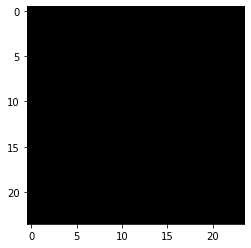

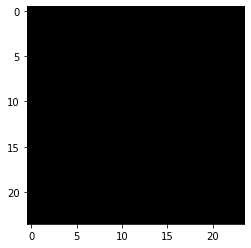

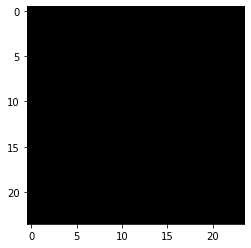

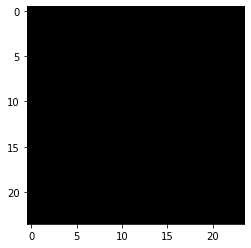

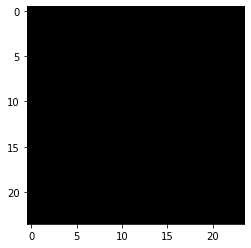

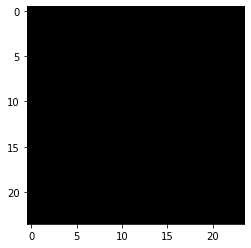

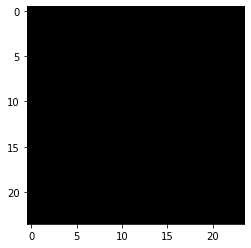

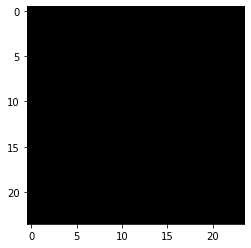

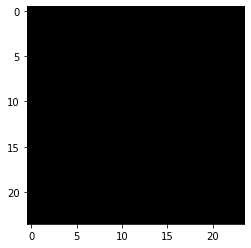

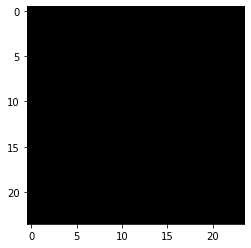

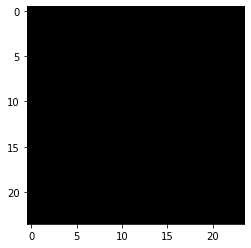

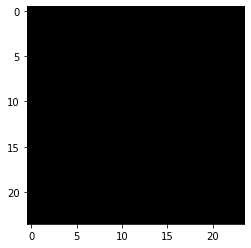

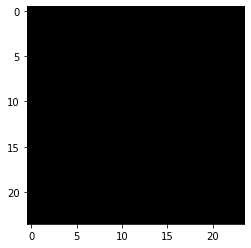

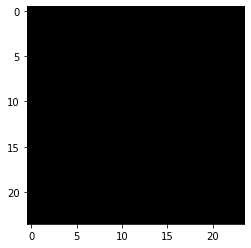

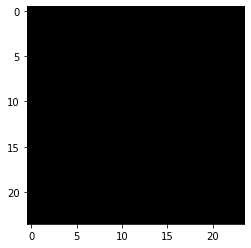

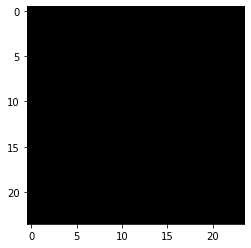

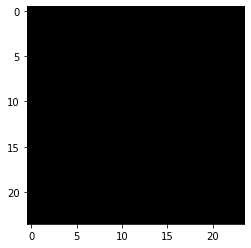

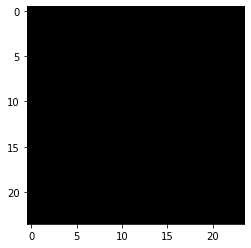

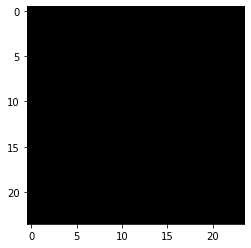

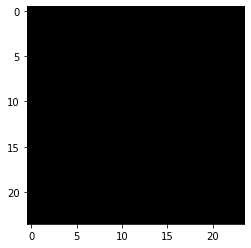

In [43]:
from cv2 import VideoWriter
import cv2
from matplotlib import pyplot as plt

# Abmessungen und Bildrate:
width, height = 48, 48
frame_rate = 10

# Der Codec. Mit diesem hier haben wir gute Erfahrungen gemacht:
codec = cv2.VideoWriter_fourcc(*'mp4v')

# So initialisieren wir den VideoWriter.
# Das erste Argument bestimmt den Pfad zur Ausgabedatei.
# Achtung: Die Abmessungen werden hier in der üblichen Reihenfolge geschrieben,
# also (Breite, Höhe) - also nicht so, wie wir es von NumPy Arrays gewohnt sind.
out = VideoWriter('film.mp4', codec, frame_rate, (width, height))

input = gen[0][0][6]


for _ in range(100):
  img = input[-1]
  plt.imshow(img, cmap='gray', vmin=0, vmax=1)
  plt.show()
  input = dream_step(model, input)
  img8bit = (img * 255.0).astype("uint8")
  img8bit = np.stack((img8bit,)*3, axis=-1)
  black_image = np.zeros((height, width, 3), "uint8")
  out.write(img8bit)
  
out.release()
cv2.destroyAllWindows()